In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import math


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 6

img_t = transform.Compose([
    transform.ToTensor()
])

train_set = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/ia/train', transform=img_t)
val_set = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/ia/val', transform=img_t)

print(len(train_set))
print(len(val_set))

cuda:0
1370
340


In [3]:
hd_resol_train = torch.utils.data.Subset(train_set, range(685))
low_resol_train = torch.utils.data.Subset(train_set, range(685, 1370))

hd_resol_val = torch.utils.data.Subset(val_set, range(0, 119))
low_resol_val = torch.utils.data.Subset(val_set, range(170, 289))

hd_resol_test = torch.utils.data.Subset(val_set, range(119, 170))
low_resol_test = torch.utils.data.Subset(val_set, range(289, 340))

In [4]:
train_loader_low = torch.utils.data.DataLoader(dataset=low_resol_train, batch_size=batch_size, shuffle=True)
train_loader_hd = torch.utils.data.DataLoader(dataset=hd_resol_train, batch_size=batch_size, shuffle=True) 

val_loader_low =  torch.utils.data.DataLoader(dataset=low_resol_val, batch_size=batch_size, shuffle=True)
val_loader_hd =  torch.utils.data.DataLoader(dataset=hd_resol_val, batch_size=batch_size, shuffle=True)

test_loader_low =  torch.utils.data.DataLoader(dataset=low_resol_test, batch_size=17, shuffle=True)
test_loader_hd =  torch.utils.data.DataLoader(dataset=hd_resol_test, batch_size=17, shuffle=True)

In [21]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(2, stride = 2, return_indices=True)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.bn2 = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(2, stride = 2, return_indices=True)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(256)
    self.pool3 = nn.MaxPool2d(2, stride = 2, return_indices=True)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, stride=1, padding=0)

  def forward(self, image):
    out1 = F.relu(self.bn1(self.conv1(image)))
    out1p, ind1 = self.pool1(out1)
    out2 = F.relu(self.bn2(self.conv2(out1p)))
    out2p, ind2 = self.pool2(out2)
    out3 = F.relu(self.bn3(self.conv3(out2p)))
    out3p, ind3 = self.pool3(out3)
    out4 = self.conv4(out3p)
    z = out4
    return z, out1, ind1, out2, ind2, out3, ind3

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.convTran1 = nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size=4, stride=1, padding=1)
    self.poolT1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.convTran2 = nn.ConvTranspose2d(in_channels=256*2,out_channels=128, kernel_size=3, stride=1, padding=0)
    self.poolT2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.convTran3 = nn.ConvTranspose2d(in_channels=128*2,out_channels=64, kernel_size=3, stride=1, padding=0)
    self.poolT3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.convTran4 = nn.ConvTranspose2d(in_channels=64*2,out_channels=3, kernel_size=3, stride=1, padding=0)

    
  def forward(self, latent, out1, ind1, out2, ind2, out3, ind3):
    out_1 = self.convTran1(latent)
    out_1p = self.poolT1(out_1, ind3)
    out_1p = torch.cat([out_1p, out3], 1)
    out_2 = F.relu(self.convTran2(out_1p))
    out_2p = self.poolT2(out_2, ind2, output_size= out2.size())
    out_2p = torch.cat([out_2p, out2], 1)
    out_3 = F.relu(self.convTran3(out_2p))
    out_3p = self.poolT3(out_3, ind1)
    out_3p = torch.cat([out_3p, out1], 1)
    out_4 = self.convTran4(out_3p)
    
    return out_4

In [22]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent, out1, ind1, out2, ind2, out3, ind3 = self.encoder(x)
        x_recon = self.decoder(latent, out1, ind1, out2, ind2, out3, ind3)
        return  x_recon

In [23]:
def train(model, train_loader, train_loader_hd, val_loader, val_loader_hd, Epochs, loss_fn):
    train_loss_avg = []
    val_loss_avg = []
    for epoch in range(Epochs):
        train_loss_avg.append(0)
        num_batches = 0
        iterator = iter(train_loader_hd)
        for image_batch, _ in train_loader:
            image_batch = image_batch.to(device)
            batch_list = next(iterator)
            image_batch_hd = batch_list[0].to(device)
            image_batch_recon = model(image_batch)
            loss = loss_fn(image_batch_recon, image_batch_hd)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
            train_loss_avg[-1] += loss.item()
            num_batches += 1
        
        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
        
        iterator = iter(val_loader_hd)
        val_loss_avg.append(0)
        num_batches=0
        for image_batch, _ in val_loader:
            image_batch = image_batch.to(device)
            batch_list = next(iterator)
            image_batch_hd = batch_list[0].to(device)
            image_batch_recon = model(image_batch)
            with torch.no_grad():
                loss = loss_fn(image_batch_recon, image_batch_hd)
                val_loss_avg[-1] += loss.item()
                num_batches += 1
        val_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction validation error: %f' % (epoch+1, Epochs, val_loss_avg[-1]))
                
    return train_loss_avg, val_loss_avg

In [24]:
epochs = 10
learning_rate = 0.0001
autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)


loss_result, loss_val = train(autoencoder,train_loader_low, train_loader_hd, val_loader_low, val_loader_hd, epochs, loss_fn)

Epoch [1 / 10] average reconstruction error: 0.853255
Epoch [1 / 10] average reconstruction validation error: 0.327097
Epoch [2 / 10] average reconstruction error: 0.246241
Epoch [2 / 10] average reconstruction validation error: 0.202401
Epoch [3 / 10] average reconstruction error: 0.180241
Epoch [3 / 10] average reconstruction validation error: 0.177545
Epoch [4 / 10] average reconstruction error: 0.157315
Epoch [4 / 10] average reconstruction validation error: 0.150988
Epoch [5 / 10] average reconstruction error: 0.141618
Epoch [5 / 10] average reconstruction validation error: 0.138765
Epoch [6 / 10] average reconstruction error: 0.132777
Epoch [6 / 10] average reconstruction validation error: 0.129303
Epoch [7 / 10] average reconstruction error: 0.127513
Epoch [7 / 10] average reconstruction validation error: 0.122416
Epoch [8 / 10] average reconstruction error: 0.119888
Epoch [8 / 10] average reconstruction validation error: 0.120951
Epoch [9 / 10] average reconstruction error: 0.1

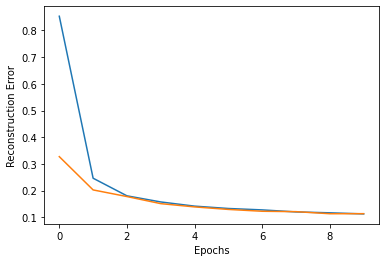

In [25]:
fig = plt.figure()
plt.plot(loss_result)
plt.plot(loss_val)
plt.xlabel("Epochs")
plt.ylabel("Reconstruction Error")
plt.show()

In [26]:
for image_batch, _ in train_loader_low:
  image_batch = image_batch.to(device)
  image_batch_recon = autoencoder(image_batch) 
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


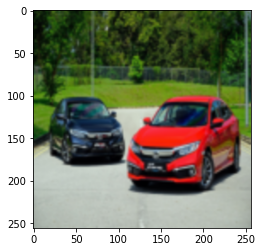

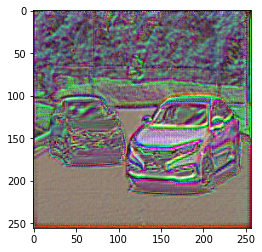

In [27]:
# display original
i = 0

im = image_batch[i].permute(1,2,0)
im2 = image_batch_recon[i].permute(1, 2, 0)
plt.figure()
plt.imshow(im.cpu())
plt.figure()
plt.imshow(im2.cpu().detach().numpy())